# Baseline

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import model_selection

import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
DATA_PATH = "../input/"
PIXEL_COLS = [str(i) for i in range(784)]
DEVICE = "cuda"

## Data

In [4]:
df = pd.read_csv(DATA_PATH + "train.csv")
df.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


In [5]:
digits = df.digit.values
letters = df.letter.values
images = df[PIXEL_COLS].values

3 N


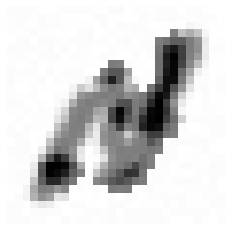

In [6]:
idx = np.random.randint(len(images))
image = images[idx].reshape((28, 28))
print(digits[idx], letters[idx])
plt.imshow(image, plt.cm.binary)
plt.axis("off");

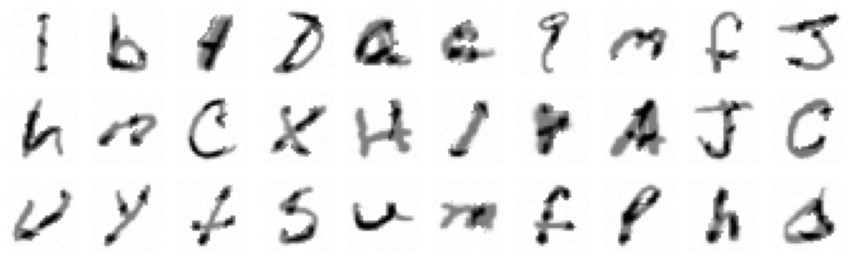

In [7]:
plt.figure(figsize=(15, 4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(images[i].reshape(28, 28), plt.cm.binary)
    plt.axis("off")
plt.show()

In [8]:
MEAN = np.mean(images / 255.0)
STD = np.std(images / 255.0)
MEAN, STD

(0.14296817848233043, 0.2537516572364304)

## Dataset

In [9]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.images = df[PIXEL_COLS].values
        self.images = self.images
        
        self.targets = df.digit.values
        
        self.augs = A.Compose(
            [
#                 A.ShiftScaleRotate(
#                     shift_limit=0.0625,
#                     scale_limit=0.1,
#                     rotate_limit=10,
#                     p=0.9,
#                 ),
                A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0, always_apply=True)
            ]
        )
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        image = self.images[item]
        
#         image = np.where(image >= 150, image, 0)

        image = image.astype(np.uint8)
        image = image.reshape(28, 28, 1)
        image = self.augs(image=image)["image"]
        image = torch.tensor(image, dtype=torch.float)
        image = image.permute(2, 0, 1)
        
        target = self.targets[item]
        target = torch.tensor(target, dtype=torch.long)
        
        return {"image": image, "target": target}

In [10]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, stratify=df.digit)

In [11]:
train_dataset = TrainDataset(df_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [12]:
valid_dataset = TrainDataset(df_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128)

## Model

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=13)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, 3)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.conv2_3 = nn.Conv2d(64, 64, 5, stride=2, padding=11)
        self.bn2_3 = nn.BatchNorm2d(64)
        
        self.conv3_1 = nn.Conv2d(64, 128, 4)
        self.bn3_1 = nn.BatchNorm2d(128)
        
        self.out = nn.Linear(28800, 10)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.dropout(x, p=0.4)
        
        x = F.relu(self.conv2_1(x))
        x = self.bn2_1(x)
        x = F.relu(self.conv2_2(x))
        x = self.bn2_2(x)
        x = F.relu(self.conv2_3(x))
        x = self.bn2_3(x)
        x = F.dropout(x, p=0.4)
        
        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = x.view(-1, 28800)
        x = F.dropout(x, p=0.4)
        x = self.out(x)
        
        return x

## Train

In [25]:
def train(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    for data in data_loader:
        inputs = data["image"]
        targets = data["target"]
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()

        
def evaluate(data_loader, model, device):
    model.eval()
    final_outputs = []
    final_targets = []
    with torch.no_grad():
        for data in data_loader:
            inputs = data["image"]
            inputs = inputs.to(device)
            targets = data["target"]
            
            outputs = model(inputs)
            outputs = outputs.detach().cpu().numpy().tolist()
            
            targets = targets.numpy().tolist()
            
            final_outputs.extend(outputs)
            final_targets.extend(targets)
            
    return final_outputs, final_targets

In [26]:
device = torch.device(DEVICE)
EPOCHS = 200

In [28]:
model = Model()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', verbose=True, patience=10, factor=0.5)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=EPOCHS)


for epoch in range(EPOCHS):
    train(train_loader, model, optimizer, device)
    predictions, targets = evaluate(valid_loader, model, device)
    
    predictions = np.array(predictions)
    predictions = np.argmax(predictions, axis=1)
    accuracy = metrics.accuracy_score(targets, predictions)
    print(f"Epoch: {epoch}, Accuracy={accuracy}")
    
    scheduler.step(accuracy)

Epoch: 0, Accuracy=0.375609756097561
Epoch: 1, Accuracy=0.375609756097561
Epoch: 2, Accuracy=0.6341463414634146
Epoch: 3, Accuracy=0.6487804878048781
Epoch: 4, Accuracy=0.6829268292682927
Epoch: 5, Accuracy=0.6780487804878049
Epoch: 6, Accuracy=0.7268292682926829
Epoch: 7, Accuracy=0.7024390243902439
Epoch: 8, Accuracy=0.6780487804878049
Epoch: 9, Accuracy=0.7560975609756098
Epoch: 10, Accuracy=0.7707317073170732
Epoch: 11, Accuracy=0.7951219512195122
Epoch: 12, Accuracy=0.775609756097561
Epoch: 13, Accuracy=0.7414634146341463
Epoch: 14, Accuracy=0.7560975609756098
Epoch: 15, Accuracy=0.7902439024390244
Epoch: 16, Accuracy=0.8
Epoch: 17, Accuracy=0.7853658536585366
Epoch: 18, Accuracy=0.8341463414634146
Epoch: 19, Accuracy=0.8146341463414634
Epoch: 20, Accuracy=0.7414634146341463
Epoch: 21, Accuracy=0.8097560975609757
Epoch: 22, Accuracy=0.7317073170731707
Epoch: 23, Accuracy=0.8634146341463415
Epoch: 24, Accuracy=0.8097560975609757
Epoch: 25, Accuracy=0.8341463414634146
Epoch: 26, Acc

Epoch: 189, Accuracy=0.8634146341463415
Epoch: 190, Accuracy=0.8926829268292683
Epoch: 191, Accuracy=0.8731707317073171
Epoch: 192, Accuracy=0.8634146341463415
Epoch: 193, Accuracy=0.848780487804878
Epoch   194: reducing learning rate of group 0 to 6.1035e-08.
Epoch: 194, Accuracy=0.8780487804878049
Epoch: 195, Accuracy=0.8634146341463415
Epoch: 196, Accuracy=0.8926829268292683
Epoch: 197, Accuracy=0.8780487804878049
Epoch: 198, Accuracy=0.8780487804878049
Epoch: 199, Accuracy=0.9121951219512195


In [18]:
torch.save(model.state_dict(), "../models/baseline_grad_clip.pt")

## Inference

In [19]:
model = Model()
model.load_state_dict(torch.load("../models/baseline_grad_clip.pt"))

<All keys matched successfully>

In [43]:
df_test = pd.read_csv(DATA_PATH + "test.csv")
df_test.head()

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4


In [44]:
class EMNISTTestDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.images = df[PIXEL_COLS].values
        self.augs = A.Compose(
            [
                A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0, always_apply=True),
            ]
        )
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        image = self.images[item]
        image = image.astype(np.uint8)
        image = image.reshape(28, 28, 1)
        image = self.augs(image)["image"]
        image = torch.tensor(image, dtype=torch.float)
        image = image.permute(2, 0, 1)
        
        return {"image": image}

In [45]:
test_dataset = EMNISTTestDataset(df_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

In [46]:
def infer(data_loader, model, device):
    model.eval()
    
    final_predictions = []
    for data in data_loader:
        images = data["image"]
        images = images.to(device)
        
        predictions = model(images)
        
        predictions = predictions.detach().cpu().numpy().tolist()
        final_predictions.extend(predictions)
        
    return final_predictions

In [31]:
model.to(device)

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(13, 13))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_3): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(11, 11))
  (bn2_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(64, 128, kernel_size=(4, 4

In [ ]:
predictions = infer(test_loader, model, device)
predictions = np.array(predictions)
predictions = np.argmax(predictions, axis=1)

In [ ]:
submission = pd.DataFrame({"id": df_test.id, "digit": predictions})
submission.to_csv("../output/baseline.csv", index=False)

In [ ]:
submission.head()